In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import random
import itertools
import time
import math

In [2]:
#Viral dynamics parameter
CL = 23
lambdaT = 2e9
deltaT = 0.02
deltaT1 = 0.5
deltaT2 = 1.4
deltaPICT = 0.35
kT = 0.35
betaT0 = 8e-12
NThat = 1000
NT = 670  #NT = 0.67*NThat
NTdiff = NThat-NT

lambdaM = 6.9e7
deltaM = 0.0069; deltaM1 = 0.0069
deltaM2 = 0.09
deltaPICM = 0.0035
kM = 0.07
betaM0 = 1e-13
NMhat = 100
NM = 67
NMdiff = NMhat-NM

#Steady States
Tu0 = 20521975484.695423
T10 =  1871843034.3127716
T20 =  467974209.5123621
V0= 13690540081.832031
VNI0=  6834284839.026645

Mu0 =  6764846776.601595
M10 =  111822300.88519625
M20 =  84484727.48236099

In [3]:
#PD parameters
IC50 = 458 #estimated
m = 1 #fixed

#Estimated PK parameter
hour = 24
ka = 45.4382*hour
k10 =  0.2355*hour
k12 =  0.175*hour
k21 =  0.0259*hour
Vc =  162.690 #mL

k13 = 44.2394*hour
k30 = 0.00975*hour

In [4]:
def eta(D):
    return D**m/(IC50**m + D**m)
    
def betaT(D):
    return betaT0*(1-eta(D))
                
def CLT(D):
    return (1 + eta(D))*betaT0

def betaM(D):
    return betaM0*(1-eta(D))
                
def CLM(D):
    return (1 + eta(D))*betaM0
 
def ode_complex(t, z, params):
    global IC50 
    IC50 = params['IC50'].value #parameter to estimate
    Tu = z[0]; T1 = z[1]; T2 = z[2]; V = z[3] #T-cells and free infectious viruses
    Mu = z[4]; M1 = z[5]; M2 = z[6]; VN = z[7] #Macrophages and non-infectious viruses
    Z0 = z[8]; Z1 = z[9]; Z2 = z[10]; Z3 = z[11] 
    #Viral dnymacics model
    dTu = lambdaT - deltaT*Tu - betaT(Z3)*V*Tu + deltaPICT*T1
    dMu = lambdaM - deltaM*Mu - betaM(Z3)*V*Mu + deltaPICM*M1
    dT1 = betaT(Z3)*V*Tu - (deltaT1 + kT + deltaPICT)*T1
    dM1 = betaM(Z3)*V*Mu - (deltaM1 + kM + deltaPICM)*M1
    dT2 = kT*T1 - deltaT2*T2
    dM2 = kM*M1 - deltaM2*M2 
    dV = NM*M2 + NT*T2 - V*(CL + (betaT(Z3)+CLT(Z3))*Tu + (CLM(Z3) + betaM(Z3))*Mu)
    dVN = (NTdiff*T2 + NMdiff*M2) - CL*VN
    #Compartment model
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    dZ3 = k13*Z1 - k30*Z3
    d = [dTu,dT1,dT2,dV,dMu,dM1,dM2,dVN,dZ0,dZ1,dZ2,dZ3]
    return d

def solve_ode_simple(z0, t_obs, params): #calculate viral load for a single data set
    deltaCV=[]
    res = solve_ivp(ode_complex, (tstart,tfinal), z0, t_eval=t_obs, args=(params,))
    V_total = res.y[3]+res.y[7]
    deltaCV.append(np.log10(V_total/V_total[0])) #total number divided by initial number of viruses
    return list(itertools.chain.from_iterable(deltaCV))

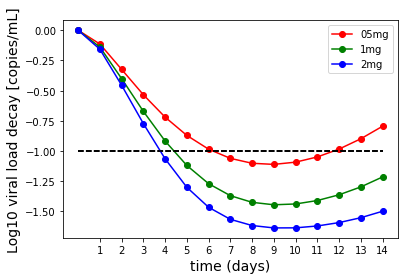

In [5]:
#plot result
dose = [0.5,1,2]

x0 = []
for i in range(len(dose)):
    x0.append([Tu0, T10, T20, V0, Mu0, M10, M20, VNI0, dose[i]*3410, 0, 0, 0])

tstart = 0; tfinal=15

parameters = Parameters()
parameters.add('IC50', value= IC50, vary = False)

l = ['05mg', '1mg', '2mg']
c = ['ro-', 'go-', 'bo-']

for i in range(len(dose)):
    res = solve_ode_simple(x0[i], range(tfinal), parameters)
    plt.plot(range(tfinal), res, c[i], label=l[i])
    plt.plot(range(tfinal), [-1]*len(range(tfinal)), 'k--')
    plt.legend()

plt.xticks(range(1,tfinal,1))
plt.xlabel('time (days)', fontsize=14)
plt.ylabel('Log10 viral load decay [copies/mL]', fontsize=14)
plt.show()